# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.241444 -1.275579  0.0  0.207457  0.982780  1.869568  0  3  22.392953   
1 -0.542430 -0.276111  0.0  0.281039  0.909502  1.522282  3  1  21.017439   
2 -0.482009 -1.289522  0.0  0.043633  0.919806  0.428575  0  0   4.995709   
3  0.421269  0.439814  0.0  0.971367  1.364451  1.418609  2  0  24.357740   
4 -1.536209 -0.543711  1.0  0.102918 -2.099364  0.166875  2  3  19.445604   

            y  
0   78.512963  
1  163.275840  
2   13.475302  
3  335.427388  
4   70.436459  
True causal estimate is 5.504005983174223


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

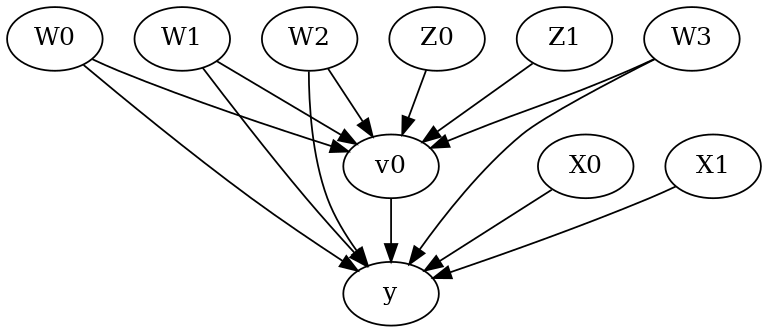

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W3,U) = P(y|v0,W1,W0,W2,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W3,U) = P(y|v0,W1,W0,W2,W3)

## Realized estimand
b: y~v0+W1+W0+W2+W3+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 5.504006374959788
### Conditional Estimates
__categorical__X1  __categorical__X0
(-4.085, -1.273]   (-4.255, -1.649]     -5.477294
                   (-1.649, -1.07]      -2.735231
                   (-1.07, -0.581]      -1.735908
                   (-0.581, 0.00289]    -0.505602
                   (0.00289, 2.782]      1.649692
(-1.273, -0.7]     (-4.255, -1.649]     -0.841902
                   (-1.649, -1.07]       1.377121
                   (-1.07, -0.581]       2.765886
                   (-0.581, 0.00289]     4.127199
                   (0.00289, 2.782]

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W3,U) = P(y|v0,W1,W0,W2,W3)

## Realized estimand
b: y~v0+W1+W0+W2+W3 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 10.924327429601346
Effect estimates: [ 4.6743093  16.97161106  7.85260807 13.50650122 11.69706827 10.55333628
  8.83761021  8.96273616  9.05920291 12.08908561 17.96180057  6.92774654
 11.19606648  6.28844797 13.32664411 16.31546568 10.3838803   7.15043459
 12.40326924 13.37571564 14.04815322 16.08425417  7.58345738  2.45103678
 14.22733034  5.82930288 13.15194828 13.23013925 16.96710788 11.46764971
 23.41490384  7.56006129 11.2763015   7.94929665 10.78097785 15.65745075
  8.99317462  5.27351835  6.05938983 11.16184007 14.43476394 13.8

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 5.504005983174223


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W3,U) = P(y|v0,W1,W0,W2,W3)

## Realized estimand
b: y~v0+W1+W0+W2+W3 | X1,X0
Target units: 

## Estimate
Mean value: 5.528577202937396
Effect estimates: [ 2.63013338  7.21085308  1.92683822 ... -0.04988012  9.91593539
 13.0732108 ]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W3,U) = P(y|v0,W1,W0,W2,W3)

## Realized estimand
b: y~v0+W1+W0+W2+W3 | X1,X0
Target units: ate

## Estimate
Mean value: 5.488679166473879
Effect estimates: [2.60811952e+00 7.13650724e+00 1.92395235e+00 ... 3.58352773e-03
 9.75073437e+00 1.29487579e+01]
95.0% confidence interval: (array([ 2.53840265,  7.18742881,  1.84633889, ..., -0.12404432,
        9.8085308 , 13.03216757]), array([ 2.70397744,  7.34574736,  1.9989278 , ...,  0.05578995,
       10.11139737, 13.39549172]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[17.12031982 14.46691298 10.97517827 16.51137561 15.10683634 16.44831796
 12.16417096 12.41266553 14.58388961 12.85367138]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     1.072389 -0.939739  0.0  0.781576 -2.510780  0.064823 -0.018632   
1    -0.217776 -1.639125  0.0  0.775978 -2.150044 -2.368232  0.226789   
2    -0.126449 -0.075358  1.0  0.999608 -0.657441 -1.012205  0.213210   
3     0.345450  1.810899  0.0  0.767309  0.025997 -3.295949  1.331601   
4    -0.092738  0.271047  0.0  0.960997 -0.651387 -0.157645  1.292071   
...        ...       ...  ...       ...       ...       ...       ...   
9995  0.958368  0.192100  0.0  0.714362  0.245868 -1.516110  0.932881   
9996  0.062608  0.210764  0.0  0.313671 -0.659727 -1.015092  1.114873   
9997  2.115321 -1.694720  0.0  0.784815  1.049689 -0.697168  0.562230   
9998  0.107898 -0.195764  0.0  0.151307  0.995922  1.266222  1.092648   
9999  0.263017  0.091418  0.0  0.893858 -2.196959 -0.910117  0.726750   

            W3  v0  y  
0     1.086318   1  1  
1     0.620849   1  0  
2     1.316023   1  1  
3    -1.065309   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W0,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W3,U) = P(y|v0,W1,W0,W2,W3)

## Realized estimand
b: y~v0+W1+W0+W2+W3 | X1,X0
Target units: ate

## Estimate
Mean value: 0.7083192088905769
Effect estimates: [0.70024589 0.58754753 0.68304574 ... 0.71503517 0.68921476 0.71450297]

True causal estimate is 0.4424


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-11-23 09:23:06.619946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 09:23:06.782326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


2022-11-23 09:23:06.782363: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-23 09:23:06.809636: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-11-23 09:23:07.591446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-23 09:23:07.591607: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-23 09:23:07.591620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2022-11-23 09:23:08.519164: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-23 09:23:08.519202: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-23 09:23:08.519226: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (62c8665ba870): /proc/driver/nvidia/version does not exist
2022-11-23 09:23:08.519989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 3:39 - loss: 193.0336

 31/313 [=>............................] - ETA: 0s - loss: 74.0531   

 61/313 [====>.........................] - ETA: 0s - loss: 41.0078

 92/313 [=======>......................] - ETA: 0s - loss: 28.7884

123/313 [==========>...................] - ETA: 0s - loss: 22.6320

154/313 [=============>................] - ETA: 0s - loss: 18.9351

186/313 [================>.............] - ETA: 0s - loss: 16.3797

217/313 [===================>..........] - ETA: 0s - loss: 14.6114

248/313 [======================>.......] - ETA: 0s - loss: 13.2831

279/313 [=========================>....] - ETA: 0s - loss: 12.2466

310/313 [============================>.] - ETA: 0s - loss: 11.4155

313/313 [==============================] - 1s 2ms/step - loss: 11.3434


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 3.7965

 33/313 [==>...........................] - ETA: 0s - loss: 3.8376

 64/313 [=====>........................] - ETA: 0s - loss: 3.8021

 95/313 [========>.....................] - ETA: 0s - loss: 3.7530

126/313 [===========>..................] - ETA: 0s - loss: 3.7028

157/313 [==============>...............] - ETA: 0s - loss: 3.6518

188/313 [=================>............] - ETA: 0s - loss: 3.5915

219/313 [===================>..........] - ETA: 0s - loss: 3.5391

250/313 [======================>.......] - ETA: 0s - loss: 3.4922

283/313 [==========================>...] - ETA: 0s - loss: 3.4397

313/313 [==============================] - 1s 2ms/step - loss: 3.3902


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 3.2750

 33/313 [==>...........................] - ETA: 0s - loss: 2.9302

 65/313 [=====>........................] - ETA: 0s - loss: 2.9299

 97/313 [========>.....................] - ETA: 0s - loss: 2.9241

128/313 [===========>..................] - ETA: 0s - loss: 2.9141

159/313 [==============>...............] - ETA: 0s - loss: 2.8938

190/313 [=================>............] - ETA: 0s - loss: 2.8925

221/313 [====================>.........] - ETA: 0s - loss: 2.8891

252/313 [=======================>......] - ETA: 0s - loss: 2.8835

283/313 [==========================>...] - ETA: 0s - loss: 2.8772

313/313 [==============================] - 1s 2ms/step - loss: 2.8663


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 2.8607

 33/313 [==>...........................] - ETA: 0s - loss: 2.7662

 64/313 [=====>........................] - ETA: 0s - loss: 2.7559

 95/313 [========>.....................] - ETA: 0s - loss: 2.7616

126/313 [===========>..................] - ETA: 0s - loss: 2.7516

158/313 [==============>...............] - ETA: 0s - loss: 2.7525

190/313 [=================>............] - ETA: 0s - loss: 2.7422

222/313 [====================>.........] - ETA: 0s - loss: 2.7483

254/313 [=======================>......] - ETA: 0s - loss: 2.7398

286/313 [==========================>...] - ETA: 0s - loss: 2.7410

313/313 [==============================] - 1s 2ms/step - loss: 2.7406


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.6566

 34/313 [==>...........................] - ETA: 0s - loss: 2.7028

 66/313 [=====>........................] - ETA: 0s - loss: 2.7058

 99/313 [========>.....................] - ETA: 0s - loss: 2.7186

131/313 [===========>..................] - ETA: 0s - loss: 2.7037

163/313 [==============>...............] - ETA: 0s - loss: 2.7039

195/313 [=================>............] - ETA: 0s - loss: 2.6956

226/313 [====================>.........] - ETA: 0s - loss: 2.6887

256/313 [=======================>......] - ETA: 0s - loss: 2.6840

287/313 [==========================>...] - ETA: 0s - loss: 2.6806

313/313 [==============================] - 1s 2ms/step - loss: 2.6777


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 3.1394

 33/313 [==>...........................] - ETA: 0s - loss: 2.6579

 65/313 [=====>........................] - ETA: 0s - loss: 2.6707

 96/313 [========>.....................] - ETA: 0s - loss: 2.6734

127/313 [===========>..................] - ETA: 0s - loss: 2.6655

159/313 [==============>...............] - ETA: 0s - loss: 2.6545

190/313 [=================>............] - ETA: 0s - loss: 2.6522

221/313 [====================>.........] - ETA: 0s - loss: 2.6502

252/313 [=======================>......] - ETA: 0s - loss: 2.6484

283/313 [==========================>...] - ETA: 0s - loss: 2.6457

313/313 [==============================] - 1s 2ms/step - loss: 2.6446


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 2.3949

 33/313 [==>...........................] - ETA: 0s - loss: 2.6315

 64/313 [=====>........................] - ETA: 0s - loss: 2.6290

 96/313 [========>.....................] - ETA: 0s - loss: 2.6387

128/313 [===========>..................] - ETA: 0s - loss: 2.6317

160/313 [==============>...............] - ETA: 0s - loss: 2.6244

192/313 [=================>............] - ETA: 0s - loss: 2.6189

223/313 [====================>.........] - ETA: 0s - loss: 2.6226

254/313 [=======================>......] - ETA: 0s - loss: 2.6258

286/313 [==========================>...] - ETA: 0s - loss: 2.6208

313/313 [==============================] - 1s 2ms/step - loss: 2.6172


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2.5374

 32/313 [==>...........................] - ETA: 0s - loss: 2.6013

 63/313 [=====>........................] - ETA: 0s - loss: 2.6083

 95/313 [========>.....................] - ETA: 0s - loss: 2.6014

127/313 [===========>..................] - ETA: 0s - loss: 2.5988

159/313 [==============>...............] - ETA: 0s - loss: 2.6047

190/313 [=================>............] - ETA: 0s - loss: 2.6051

221/313 [====================>.........] - ETA: 0s - loss: 2.6085

252/313 [=======================>......] - ETA: 0s - loss: 2.6040

283/313 [==========================>...] - ETA: 0s - loss: 2.6024

313/313 [==============================] - 1s 2ms/step - loss: 2.6038


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 2.4114

 33/313 [==>...........................] - ETA: 0s - loss: 2.6075

 65/313 [=====>........................] - ETA: 0s - loss: 2.5992

 97/313 [========>.....................] - ETA: 0s - loss: 2.5934

129/313 [===========>..................] - ETA: 0s - loss: 2.5832

162/313 [==============>...............] - ETA: 0s - loss: 2.5781

194/313 [=================>............] - ETA: 0s - loss: 2.5788

225/313 [====================>.........] - ETA: 0s - loss: 2.5746

256/313 [=======================>......] - ETA: 0s - loss: 2.5758

287/313 [==========================>...] - ETA: 0s - loss: 2.5758

313/313 [==============================] - 1s 2ms/step - loss: 2.5755


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 2.6053

 33/313 [==>...........................] - ETA: 0s - loss: 2.5672

 64/313 [=====>........................] - ETA: 0s - loss: 2.5576

 95/313 [========>.....................] - ETA: 0s - loss: 2.5645

126/313 [===========>..................] - ETA: 0s - loss: 2.5634

157/313 [==============>...............] - ETA: 0s - loss: 2.5699

189/313 [=================>............] - ETA: 0s - loss: 2.5841

220/313 [====================>.........] - ETA: 0s - loss: 2.5844

252/313 [=======================>......] - ETA: 0s - loss: 2.5803

283/313 [==========================>...] - ETA: 0s - loss: 2.5788

313/313 [==============================] - 1s 2ms/step - loss: 2.5770


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.7507

 33/313 [==>...........................] - ETA: 0s - loss: 2.5949

 66/313 [=====>........................] - ETA: 0s - loss: 2.5591

 97/313 [========>.....................] - ETA: 0s - loss: 2.5584

128/313 [===========>..................] - ETA: 0s - loss: 2.5619

160/313 [==============>...............] - ETA: 0s - loss: 2.5602

191/313 [=================>............] - ETA: 0s - loss: 2.5648

223/313 [====================>.........] - ETA: 0s - loss: 2.5682

254/313 [=======================>......] - ETA: 0s - loss: 2.5647

286/313 [==========================>...] - ETA: 0s - loss: 2.5640

313/313 [==============================] - 1s 2ms/step - loss: 2.5610


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 2.4811

 33/313 [==>...........................] - ETA: 0s - loss: 2.5237

 65/313 [=====>........................] - ETA: 0s - loss: 2.5453

 97/313 [========>.....................] - ETA: 0s - loss: 2.5466

129/313 [===========>..................] - ETA: 0s - loss: 2.5424

161/313 [==============>...............] - ETA: 0s - loss: 2.5398

193/313 [=================>............] - ETA: 0s - loss: 2.5373

225/313 [====================>.........] - ETA: 0s - loss: 2.5435

256/313 [=======================>......] - ETA: 0s - loss: 2.5469

287/313 [==========================>...] - ETA: 0s - loss: 2.5509

313/313 [==============================] - 1s 2ms/step - loss: 2.5485


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2.5226

 32/313 [==>...........................] - ETA: 0s - loss: 2.5203

 63/313 [=====>........................] - ETA: 0s - loss: 2.5217

 94/313 [========>.....................] - ETA: 0s - loss: 2.5236

126/313 [===========>..................] - ETA: 0s - loss: 2.5367

157/313 [==============>...............] - ETA: 0s - loss: 2.5364

188/313 [=================>............] - ETA: 0s - loss: 2.5384

219/313 [===================>..........] - ETA: 0s - loss: 2.5367

250/313 [======================>.......] - ETA: 0s - loss: 2.5416

280/313 [=========================>....] - ETA: 0s - loss: 2.5420

311/313 [============================>.] - ETA: 0s - loss: 2.5428

313/313 [==============================] - 1s 2ms/step - loss: 2.5424


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.4913

 32/313 [==>...........................] - ETA: 0s - loss: 2.5934

 63/313 [=====>........................] - ETA: 0s - loss: 2.5665

 94/313 [========>.....................] - ETA: 0s - loss: 2.5735

125/313 [==========>...................] - ETA: 0s - loss: 2.5592

156/313 [=============>................] - ETA: 0s - loss: 2.5564

188/313 [=================>............] - ETA: 0s - loss: 2.5459

219/313 [===================>..........] - ETA: 0s - loss: 2.5455

250/313 [======================>.......] - ETA: 0s - loss: 2.5481

281/313 [=========================>....] - ETA: 0s - loss: 2.5409

312/313 [============================>.] - ETA: 0s - loss: 2.5406

313/313 [==============================] - 1s 2ms/step - loss: 2.5398


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 2.3535

 32/313 [==>...........................] - ETA: 0s - loss: 2.5066

 63/313 [=====>........................] - ETA: 0s - loss: 2.4951

 95/313 [========>.....................] - ETA: 0s - loss: 2.5170

126/313 [===========>..................] - ETA: 0s - loss: 2.5286

158/313 [==============>...............] - ETA: 0s - loss: 2.5244

189/313 [=================>............] - ETA: 0s - loss: 2.5244

221/313 [====================>.........] - ETA: 0s - loss: 2.5199

253/313 [=======================>......] - ETA: 0s - loss: 2.5192

284/313 [==========================>...] - ETA: 0s - loss: 2.5162

313/313 [==============================] - 1s 2ms/step - loss: 2.5202


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 2.7270

 32/313 [==>...........................] - ETA: 0s - loss: 2.4841

 64/313 [=====>........................] - ETA: 0s - loss: 2.5265

 95/313 [========>.....................] - ETA: 0s - loss: 2.5248

126/313 [===========>..................] - ETA: 0s - loss: 2.5185

158/313 [==============>...............] - ETA: 0s - loss: 2.5227

190/313 [=================>............] - ETA: 0s - loss: 2.5229

222/313 [====================>.........] - ETA: 0s - loss: 2.5225

254/313 [=======================>......] - ETA: 0s - loss: 2.5178

285/313 [==========================>...] - ETA: 0s - loss: 2.5182

313/313 [==============================] - 1s 2ms/step - loss: 2.5178


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 2.6178

 33/313 [==>...........................] - ETA: 0s - loss: 2.4838

 65/313 [=====>........................] - ETA: 0s - loss: 2.4896

 97/313 [========>.....................] - ETA: 0s - loss: 2.5096

129/313 [===========>..................] - ETA: 0s - loss: 2.5077

161/313 [==============>...............] - ETA: 0s - loss: 2.5036

192/313 [=================>............] - ETA: 0s - loss: 2.4956

221/313 [====================>.........] - ETA: 0s - loss: 2.4949

251/313 [=======================>......] - ETA: 0s - loss: 2.4950

281/313 [=========================>....] - ETA: 0s - loss: 2.4947

312/313 [============================>.] - ETA: 0s - loss: 2.4894

313/313 [==============================] - 1s 2ms/step - loss: 2.4892


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 2.3942

 32/313 [==>...........................] - ETA: 0s - loss: 2.5070

 63/313 [=====>........................] - ETA: 0s - loss: 2.4846

 94/313 [========>.....................] - ETA: 0s - loss: 2.4951

125/313 [==========>...................] - ETA: 0s - loss: 2.4848

156/313 [=============>................] - ETA: 0s - loss: 2.4889

188/313 [=================>............] - ETA: 0s - loss: 2.4918

219/313 [===================>..........] - ETA: 0s - loss: 2.4892

251/313 [=======================>......] - ETA: 0s - loss: 2.4876

283/313 [==========================>...] - ETA: 0s - loss: 2.4895

313/313 [==============================] - 1s 2ms/step - loss: 2.4882


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 2.2294

 34/313 [==>...........................] - ETA: 0s - loss: 2.4258

 66/313 [=====>........................] - ETA: 0s - loss: 2.4519

 98/313 [========>.....................] - ETA: 0s - loss: 2.4655

129/313 [===========>..................] - ETA: 0s - loss: 2.4666

161/313 [==============>...............] - ETA: 0s - loss: 2.4792

192/313 [=================>............] - ETA: 0s - loss: 2.4784

223/313 [====================>.........] - ETA: 0s - loss: 2.4785

255/313 [=======================>......] - ETA: 0s - loss: 2.4817

287/313 [==========================>...] - ETA: 0s - loss: 2.4795

313/313 [==============================] - 1s 2ms/step - loss: 2.4818


Epoch 20/25


  1/313 [..............................] - ETA: 0s - loss: 2.4164

 33/313 [==>...........................] - ETA: 0s - loss: 2.4721

 65/313 [=====>........................] - ETA: 0s - loss: 2.4702

 97/313 [========>.....................] - ETA: 0s - loss: 2.4613

129/313 [===========>..................] - ETA: 0s - loss: 2.4754

161/313 [==============>...............] - ETA: 0s - loss: 2.4795

193/313 [=================>............] - ETA: 0s - loss: 2.4820

224/313 [====================>.........] - ETA: 0s - loss: 2.4829

255/313 [=======================>......] - ETA: 0s - loss: 2.4796

287/313 [==========================>...] - ETA: 0s - loss: 2.4786

313/313 [==============================] - 1s 2ms/step - loss: 2.4777


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.5278

 33/313 [==>...........................] - ETA: 0s - loss: 2.4675

 66/313 [=====>........................] - ETA: 0s - loss: 2.4682

 98/313 [========>.....................] - ETA: 0s - loss: 2.4615

130/313 [===========>..................] - ETA: 0s - loss: 2.4687

161/313 [==============>...............] - ETA: 0s - loss: 2.4662

193/313 [=================>............] - ETA: 0s - loss: 2.4705

225/313 [====================>.........] - ETA: 0s - loss: 2.4696

257/313 [=======================>......] - ETA: 0s - loss: 2.4698

290/313 [==========================>...] - ETA: 0s - loss: 2.4689

313/313 [==============================] - 1s 2ms/step - loss: 2.4701


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2.7940

 33/313 [==>...........................] - ETA: 0s - loss: 2.4594

 65/313 [=====>........................] - ETA: 0s - loss: 2.4527

 97/313 [========>.....................] - ETA: 0s - loss: 2.4482

129/313 [===========>..................] - ETA: 0s - loss: 2.4487

162/313 [==============>...............] - ETA: 0s - loss: 2.4574

194/313 [=================>............] - ETA: 0s - loss: 2.4647

225/313 [====================>.........] - ETA: 0s - loss: 2.4583

256/313 [=======================>......] - ETA: 0s - loss: 2.4628

287/313 [==========================>...] - ETA: 0s - loss: 2.4617

313/313 [==============================] - 1s 2ms/step - loss: 2.4639


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.4714

 33/313 [==>...........................] - ETA: 0s - loss: 2.4404

 64/313 [=====>........................] - ETA: 0s - loss: 2.4410

 95/313 [========>.....................] - ETA: 0s - loss: 2.4513

126/313 [===========>..................] - ETA: 0s - loss: 2.4643

158/313 [==============>...............] - ETA: 0s - loss: 2.4594

190/313 [=================>............] - ETA: 0s - loss: 2.4608

221/313 [====================>.........] - ETA: 0s - loss: 2.4582

252/313 [=======================>......] - ETA: 0s - loss: 2.4591

284/313 [==========================>...] - ETA: 0s - loss: 2.4618

313/313 [==============================] - 1s 2ms/step - loss: 2.4633


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 2.4648

 33/313 [==>...........................] - ETA: 0s - loss: 2.4122

 65/313 [=====>........................] - ETA: 0s - loss: 2.4450

 98/313 [========>.....................] - ETA: 0s - loss: 2.4540

130/313 [===========>..................] - ETA: 0s - loss: 2.4609

162/313 [==============>...............] - ETA: 0s - loss: 2.4566

193/313 [=================>............] - ETA: 0s - loss: 2.4521

225/313 [====================>.........] - ETA: 0s - loss: 2.4535

257/313 [=======================>......] - ETA: 0s - loss: 2.4548

289/313 [==========================>...] - ETA: 0s - loss: 2.4537

313/313 [==============================] - 0s 2ms/step - loss: 2.4542


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2.4049

 33/313 [==>...........................] - ETA: 0s - loss: 2.4490

 65/313 [=====>........................] - ETA: 0s - loss: 2.4635

 97/313 [========>.....................] - ETA: 0s - loss: 2.4531

129/313 [===========>..................] - ETA: 0s - loss: 2.4531

161/313 [==============>...............] - ETA: 0s - loss: 2.4514

192/313 [=================>............] - ETA: 0s - loss: 2.4496

224/313 [====================>.........] - ETA: 0s - loss: 2.4534

256/313 [=======================>......] - ETA: 0s - loss: 2.4534

287/313 [==========================>...] - ETA: 0s - loss: 2.4547

313/313 [==============================] - 1s 2ms/step - loss: 2.4532


Epoch 1/25


  1/313 [..............................] - ETA: 4:20 - loss: 30090.2969

 26/313 [=>............................] - ETA: 0s - loss: 26016.4395  

 51/313 [===>..........................] - ETA: 0s - loss: 22697.7090

 76/313 [======>.......................] - ETA: 0s - loss: 21149.9062

102/313 [========>.....................] - ETA: 0s - loss: 20271.5957

128/313 [===========>..................] - ETA: 0s - loss: 21558.6719

154/313 [=============>................] - ETA: 0s - loss: 20649.0684

179/313 [================>.............] - ETA: 0s - loss: 19902.8984

204/313 [==================>...........] - ETA: 0s - loss: 19034.0566

230/313 [=====================>........] - ETA: 0s - loss: 18264.9395

256/313 [=======================>......] - ETA: 0s - loss: 17441.7676

282/313 [==========================>...] - ETA: 0s - loss: 16664.0371

308/313 [============================>.] - ETA: 0s - loss: 15884.6172

313/313 [==============================] - 1s 2ms/step - loss: 15777.3994


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 5670.0352

 27/313 [=>............................] - ETA: 0s - loss: 7587.1187

 52/313 [===>..........................] - ETA: 0s - loss: 7443.6333

 78/313 [======>.......................] - ETA: 0s - loss: 7246.5601

103/313 [========>.....................] - ETA: 0s - loss: 6986.2681

129/313 [===========>..................] - ETA: 0s - loss: 7054.9888

155/313 [=============>................] - ETA: 0s - loss: 6851.0308

180/313 [================>.............] - ETA: 0s - loss: 6824.1445

206/313 [==================>...........] - ETA: 0s - loss: 6809.1021

231/313 [=====================>........] - ETA: 0s - loss: 6757.9360

256/313 [=======================>......] - ETA: 0s - loss: 6687.1733

282/313 [==========================>...] - ETA: 0s - loss: 6613.0840

308/313 [============================>.] - ETA: 0s - loss: 6549.1313

313/313 [==============================] - 1s 2ms/step - loss: 6510.4067


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 8052.9004

 27/313 [=>............................] - ETA: 0s - loss: 6471.4927

 52/313 [===>..........................] - ETA: 0s - loss: 6034.2812

 77/313 [======>.......................] - ETA: 0s - loss: 5998.6572

102/313 [========>.....................] - ETA: 0s - loss: 5987.0356

127/313 [===========>..................] - ETA: 0s - loss: 6030.8301

152/313 [=============>................] - ETA: 0s - loss: 5877.6045

177/313 [===============>..............] - ETA: 0s - loss: 5764.4448

203/313 [==================>...........] - ETA: 0s - loss: 6296.7119

229/313 [====================>.........] - ETA: 0s - loss: 6280.9658

255/313 [=======================>......] - ETA: 0s - loss: 6278.5698

281/313 [=========================>....] - ETA: 0s - loss: 6206.6929

307/313 [============================>.] - ETA: 0s - loss: 6150.1611

313/313 [==============================] - 1s 2ms/step - loss: 6125.6978


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 8966.1953

 27/313 [=>............................] - ETA: 0s - loss: 77550.1641

 53/313 [====>.........................] - ETA: 0s - loss: 42368.3008

 78/313 [======>.......................] - ETA: 0s - loss: 30747.0098

105/313 [=========>....................] - ETA: 0s - loss: 24326.1152

132/313 [===========>..................] - ETA: 0s - loss: 20447.0312

158/313 [==============>...............] - ETA: 0s - loss: 17982.4570

183/313 [================>.............] - ETA: 0s - loss: 16231.6270

210/313 [===================>..........] - ETA: 0s - loss: 14776.9258

236/313 [=====================>........] - ETA: 0s - loss: 13759.2217

262/313 [========================>.....] - ETA: 0s - loss: 13070.2930

288/313 [==========================>...] - ETA: 0s - loss: 12382.4922

313/313 [==============================] - 1s 2ms/step - loss: 11769.2676


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 4210.9258

 28/313 [=>............................] - ETA: 0s - loss: 5271.5718

 54/313 [====>.........................] - ETA: 0s - loss: 5347.9917

 80/313 [======>.......................] - ETA: 0s - loss: 5180.9580

106/313 [=========>....................] - ETA: 0s - loss: 5190.7930

132/313 [===========>..................] - ETA: 0s - loss: 5160.5698

158/313 [==============>...............] - ETA: 0s - loss: 5245.1265

184/313 [================>.............] - ETA: 0s - loss: 5187.2451

209/313 [===================>..........] - ETA: 0s - loss: 5218.3911

235/313 [=====================>........] - ETA: 0s - loss: 5273.8882

262/313 [========================>.....] - ETA: 0s - loss: 5267.1841

288/313 [==========================>...] - ETA: 0s - loss: 5311.1113

313/313 [==============================] - 1s 2ms/step - loss: 5238.5430


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 5276.3945

 28/313 [=>............................] - ETA: 0s - loss: 5070.9194

 55/313 [====>.........................] - ETA: 0s - loss: 5226.7397

 82/313 [======>.......................] - ETA: 0s - loss: 5250.9839

109/313 [=========>....................] - ETA: 0s - loss: 5416.8359

136/313 [============>.................] - ETA: 0s - loss: 5366.3340

162/313 [==============>...............] - ETA: 0s - loss: 5342.0601

189/313 [=================>............] - ETA: 0s - loss: 5266.6396

216/313 [===================>..........] - ETA: 0s - loss: 5317.9429

243/313 [======================>.......] - ETA: 0s - loss: 5243.1250

269/313 [========================>.....] - ETA: 0s - loss: 5250.8228

294/313 [===========================>..] - ETA: 0s - loss: 5254.9897

313/313 [==============================] - 1s 2ms/step - loss: 5191.8379


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 7940.4219

 28/313 [=>............................] - ETA: 0s - loss: 5221.9326

 55/313 [====>.........................] - ETA: 0s - loss: 4912.4717

 82/313 [======>.......................] - ETA: 0s - loss: 5072.9956

109/313 [=========>....................] - ETA: 0s - loss: 5024.4312

136/313 [============>.................] - ETA: 0s - loss: 4939.4336

163/313 [==============>...............] - ETA: 0s - loss: 5144.1831

190/313 [=================>............] - ETA: 0s - loss: 5089.3706

217/313 [===================>..........] - ETA: 0s - loss: 5084.5513

244/313 [======================>.......] - ETA: 0s - loss: 5078.9028

271/313 [========================>.....] - ETA: 0s - loss: 5089.7520

297/313 [===========================>..] - ETA: 0s - loss: 5076.2769

313/313 [==============================] - 1s 2ms/step - loss: 5088.4014


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 5158.2212

 29/313 [=>............................] - ETA: 0s - loss: 4917.2490

 56/313 [====>.........................] - ETA: 0s - loss: 5226.9448

 83/313 [======>.......................] - ETA: 0s - loss: 4954.3462

109/313 [=========>....................] - ETA: 0s - loss: 5060.6709

135/313 [===========>..................] - ETA: 0s - loss: 5012.3682

161/313 [==============>...............] - ETA: 0s - loss: 5019.6621

187/313 [================>.............] - ETA: 0s - loss: 5193.6875

213/313 [===================>..........] - ETA: 0s - loss: 5118.8696

239/313 [=====================>........] - ETA: 0s - loss: 5069.8276

265/313 [========================>.....] - ETA: 0s - loss: 5067.4004

291/313 [==========================>...] - ETA: 0s - loss: 5063.2109

313/313 [==============================] - 1s 2ms/step - loss: 5049.4946


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2884.6362

 28/313 [=>............................] - ETA: 0s - loss: 4877.5234

 55/313 [====>.........................] - ETA: 0s - loss: 4874.2300

 81/313 [======>.......................] - ETA: 0s - loss: 4949.9419

107/313 [=========>....................] - ETA: 0s - loss: 5298.2656

133/313 [===========>..................] - ETA: 0s - loss: 5319.1802

159/313 [==============>...............] - ETA: 0s - loss: 5199.6719

185/313 [================>.............] - ETA: 0s - loss: 5123.6152

211/313 [===================>..........] - ETA: 0s - loss: 5149.6396

238/313 [=====================>........] - ETA: 0s - loss: 5147.2842

265/313 [========================>.....] - ETA: 0s - loss: 5143.5171

292/313 [==========================>...] - ETA: 0s - loss: 5070.4048

313/313 [==============================] - 1s 2ms/step - loss: 5049.9204


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 4906.9004

 28/313 [=>............................] - ETA: 0s - loss: 5970.6143

 55/313 [====>.........................] - ETA: 0s - loss: 5485.4189

 82/313 [======>.......................] - ETA: 0s - loss: 5432.0322

109/313 [=========>....................] - ETA: 0s - loss: 5405.2690

136/313 [============>.................] - ETA: 0s - loss: 5285.1313

163/313 [==============>...............] - ETA: 0s - loss: 5179.0435

190/313 [=================>............] - ETA: 0s - loss: 5215.1030

216/313 [===================>..........] - ETA: 0s - loss: 5256.9883

242/313 [======================>.......] - ETA: 0s - loss: 5186.9404

268/313 [========================>.....] - ETA: 0s - loss: 5142.1147

294/313 [===========================>..] - ETA: 0s - loss: 5167.6616

313/313 [==============================] - 1s 2ms/step - loss: 5159.5205


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 3893.4858

 27/313 [=>............................] - ETA: 0s - loss: 4826.8184

 53/313 [====>.........................] - ETA: 0s - loss: 4723.3574

 79/313 [======>.......................] - ETA: 0s - loss: 4933.2534

105/313 [=========>....................] - ETA: 0s - loss: 5187.4531

130/313 [===========>..................] - ETA: 0s - loss: 5137.3423

156/313 [=============>................] - ETA: 0s - loss: 5061.8140

182/313 [================>.............] - ETA: 0s - loss: 5125.1533

209/313 [===================>..........] - ETA: 0s - loss: 5300.5645

235/313 [=====================>........] - ETA: 0s - loss: 5263.1729

262/313 [========================>.....] - ETA: 0s - loss: 5247.7217

288/313 [==========================>...] - ETA: 0s - loss: 5231.2109

313/313 [==============================] - 1s 2ms/step - loss: 5210.2651


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2247.3447

 27/313 [=>............................] - ETA: 0s - loss: 4935.4575

 53/313 [====>.........................] - ETA: 0s - loss: 4911.2798

 79/313 [======>.......................] - ETA: 0s - loss: 5368.0044

105/313 [=========>....................] - ETA: 0s - loss: 5113.0044

131/313 [===========>..................] - ETA: 0s - loss: 5140.4565

157/313 [==============>...............] - ETA: 0s - loss: 5259.8989

182/313 [================>.............] - ETA: 0s - loss: 5304.3511

208/313 [==================>...........] - ETA: 0s - loss: 5206.2900

235/313 [=====================>........] - ETA: 0s - loss: 5212.7856

261/313 [========================>.....] - ETA: 0s - loss: 5151.6831

287/313 [==========================>...] - ETA: 0s - loss: 5136.3608

313/313 [==============================] - ETA: 0s - loss: 5079.0654

313/313 [==============================] - 1s 2ms/step - loss: 5079.0654


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2837.2930

 26/313 [=>............................] - ETA: 0s - loss: 5220.0674

 52/313 [===>..........................] - ETA: 0s - loss: 5167.0757

 79/313 [======>.......................] - ETA: 0s - loss: 5086.9492

106/313 [=========>....................] - ETA: 0s - loss: 5035.3750

132/313 [===========>..................] - ETA: 0s - loss: 4994.9170

157/313 [==============>...............] - ETA: 0s - loss: 4869.7661

182/313 [================>.............] - ETA: 0s - loss: 4908.2114

208/313 [==================>...........] - ETA: 0s - loss: 4947.0591

235/313 [=====================>........] - ETA: 0s - loss: 4966.9917

261/313 [========================>.....] - ETA: 0s - loss: 5038.1899

287/313 [==========================>...] - ETA: 0s - loss: 5039.3486

313/313 [==============================] - ETA: 0s - loss: 5067.8960

313/313 [==============================] - 1s 2ms/step - loss: 5067.8960


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 4123.4536

 27/313 [=>............................] - ETA: 0s - loss: 4746.2793

 53/313 [====>.........................] - ETA: 0s - loss: 4383.8784

 79/313 [======>.......................] - ETA: 0s - loss: 4326.9956

105/313 [=========>....................] - ETA: 0s - loss: 4357.5859

131/313 [===========>..................] - ETA: 0s - loss: 4535.5347

157/313 [==============>...............] - ETA: 0s - loss: 4567.5229

183/313 [================>.............] - ETA: 0s - loss: 4643.9609

209/313 [===================>..........] - ETA: 0s - loss: 4670.5522

235/313 [=====================>........] - ETA: 0s - loss: 4706.1494

261/313 [========================>.....] - ETA: 0s - loss: 4880.1934

287/313 [==========================>...] - ETA: 0s - loss: 4867.1265

313/313 [==============================] - ETA: 0s - loss: 4980.1538

313/313 [==============================] - 1s 2ms/step - loss: 4980.1538


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 4438.5762

 27/313 [=>............................] - ETA: 0s - loss: 5046.8774

 53/313 [====>.........................] - ETA: 0s - loss: 4803.6274

 78/313 [======>.......................] - ETA: 0s - loss: 4806.2183

103/313 [========>.....................] - ETA: 0s - loss: 4971.3096

129/313 [===========>..................] - ETA: 0s - loss: 4876.5420

155/313 [=============>................] - ETA: 0s - loss: 4857.8594

181/313 [================>.............] - ETA: 0s - loss: 4849.6519

207/313 [==================>...........] - ETA: 0s - loss: 4961.5151

233/313 [=====================>........] - ETA: 0s - loss: 4921.6084

259/313 [=======================>......] - ETA: 0s - loss: 4935.8975

285/313 [==========================>...] - ETA: 0s - loss: 4908.3149

311/313 [============================>.] - ETA: 0s - loss: 4973.1226

313/313 [==============================] - 1s 2ms/step - loss: 4979.3452


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 5619.4932

 28/313 [=>............................] - ETA: 0s - loss: 5073.1743

 54/313 [====>.........................] - ETA: 0s - loss: 5309.6089

 81/313 [======>.......................] - ETA: 0s - loss: 5335.8242

108/313 [=========>....................] - ETA: 0s - loss: 5133.8882

135/313 [===========>..................] - ETA: 0s - loss: 5196.8032

162/313 [==============>...............] - ETA: 0s - loss: 5178.2817

188/313 [=================>............] - ETA: 0s - loss: 5140.2183

215/313 [===================>..........] - ETA: 0s - loss: 5062.2920

242/313 [======================>.......] - ETA: 0s - loss: 5020.7446

269/313 [========================>.....] - ETA: 0s - loss: 5022.3135

296/313 [===========================>..] - ETA: 0s - loss: 4981.7900

313/313 [==============================] - 1s 2ms/step - loss: 4960.4536


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 3526.6162

 28/313 [=>............................] - ETA: 0s - loss: 4881.4233

 55/313 [====>.........................] - ETA: 0s - loss: 5406.3853

 81/313 [======>.......................] - ETA: 0s - loss: 5371.4629

107/313 [=========>....................] - ETA: 0s - loss: 5282.8682

133/313 [===========>..................] - ETA: 0s - loss: 5204.2207

158/313 [==============>...............] - ETA: 0s - loss: 5254.3169

183/313 [================>.............] - ETA: 0s - loss: 5314.9395

208/313 [==================>...........] - ETA: 0s - loss: 5176.5449

233/313 [=====================>........] - ETA: 0s - loss: 5072.5918

259/313 [=======================>......] - ETA: 0s - loss: 5103.4961

284/313 [==========================>...] - ETA: 0s - loss: 5109.3462

309/313 [============================>.] - ETA: 0s - loss: 5081.4155

313/313 [==============================] - 1s 2ms/step - loss: 5076.7163


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 3899.4175

 26/313 [=>............................] - ETA: 0s - loss: 5481.8481

 52/313 [===>..........................] - ETA: 0s - loss: 5058.2969

 78/313 [======>.......................] - ETA: 0s - loss: 5239.0254

105/313 [=========>....................] - ETA: 0s - loss: 5268.1904

132/313 [===========>..................] - ETA: 0s - loss: 5318.1323

159/313 [==============>...............] - ETA: 0s - loss: 5244.2969

185/313 [================>.............] - ETA: 0s - loss: 5263.6748

211/313 [===================>..........] - ETA: 0s - loss: 5227.0527

235/313 [=====================>........] - ETA: 0s - loss: 5179.4653

261/313 [========================>.....] - ETA: 0s - loss: 5096.9258

287/313 [==========================>...] - ETA: 0s - loss: 5036.2925

313/313 [==============================] - ETA: 0s - loss: 5014.8057

313/313 [==============================] - 1s 2ms/step - loss: 5014.8057


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 3150.2329

 27/313 [=>............................] - ETA: 0s - loss: 4778.2417

 53/313 [====>.........................] - ETA: 0s - loss: 4623.1050

 79/313 [======>.......................] - ETA: 0s - loss: 4887.9624

105/313 [=========>....................] - ETA: 0s - loss: 4778.9761

132/313 [===========>..................] - ETA: 0s - loss: 4639.1802

158/313 [==============>...............] - ETA: 0s - loss: 4684.4199

185/313 [================>.............] - ETA: 0s - loss: 4715.8481

212/313 [===================>..........] - ETA: 0s - loss: 4802.7686

238/313 [=====================>........] - ETA: 0s - loss: 4922.7490

264/313 [========================>.....] - ETA: 0s - loss: 4939.8359

289/313 [==========================>...] - ETA: 0s - loss: 4927.3511

313/313 [==============================] - 1s 2ms/step - loss: 4975.9263


Epoch 20/25


  1/313 [..............................] - ETA: 0s - loss: 3633.0449

 28/313 [=>............................] - ETA: 0s - loss: 4685.2432

 55/313 [====>.........................] - ETA: 0s - loss: 4613.6211

 82/313 [======>.......................] - ETA: 0s - loss: 4674.3774

109/313 [=========>....................] - ETA: 0s - loss: 4819.8408

135/313 [===========>..................] - ETA: 0s - loss: 5055.2046

161/313 [==============>...............] - ETA: 0s - loss: 4998.3818

187/313 [================>.............] - ETA: 0s - loss: 4980.8818

213/313 [===================>..........] - ETA: 0s - loss: 4979.5195

239/313 [=====================>........] - ETA: 0s - loss: 4974.9766

266/313 [========================>.....] - ETA: 0s - loss: 4972.3643

292/313 [==========================>...] - ETA: 0s - loss: 4963.1201

313/313 [==============================] - 1s 2ms/step - loss: 4966.7773


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2301.3552

 28/313 [=>............................] - ETA: 0s - loss: 5210.2529

 55/313 [====>.........................] - ETA: 0s - loss: 5284.3398

 81/313 [======>.......................] - ETA: 0s - loss: 5305.3608

108/313 [=========>....................] - ETA: 0s - loss: 5142.9043

134/313 [===========>..................] - ETA: 0s - loss: 5223.2300

160/313 [==============>...............] - ETA: 0s - loss: 5222.2861

186/313 [================>.............] - ETA: 0s - loss: 5127.5005

204/313 [==================>...........] - ETA: 0s - loss: 5113.1460

230/313 [=====================>........] - ETA: 0s - loss: 5151.1333

256/313 [=======================>......] - ETA: 0s - loss: 5139.5854

281/313 [=========================>....] - ETA: 0s - loss: 5115.4741

306/313 [============================>.] - ETA: 0s - loss: 5092.7231

313/313 [==============================] - 1s 2ms/step - loss: 5081.3433


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 3978.9128

 28/313 [=>............................] - ETA: 0s - loss: 4290.9878

 54/313 [====>.........................] - ETA: 0s - loss: 4872.2749

 80/313 [======>.......................] - ETA: 0s - loss: 4730.7646

105/313 [=========>....................] - ETA: 0s - loss: 4847.2241

131/313 [===========>..................] - ETA: 0s - loss: 4854.1909

157/313 [==============>...............] - ETA: 0s - loss: 5276.1216

183/313 [================>.............] - ETA: 0s - loss: 5276.2725

207/313 [==================>...........] - ETA: 0s - loss: 5243.0415

232/313 [=====================>........] - ETA: 0s - loss: 5235.7061

256/313 [=======================>......] - ETA: 0s - loss: 5193.1328

281/313 [=========================>....] - ETA: 0s - loss: 5166.3115

306/313 [============================>.] - ETA: 0s - loss: 5182.2114

313/313 [==============================] - 1s 2ms/step - loss: 5172.1504


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2197.4121

 25/313 [=>............................] - ETA: 0s - loss: 4780.8813

 50/313 [===>..........................] - ETA: 0s - loss: 5054.8496

 74/313 [======>.......................] - ETA: 0s - loss: 4845.0234

 99/313 [========>.....................] - ETA: 0s - loss: 4883.1016

125/313 [==========>...................] - ETA: 0s - loss: 4750.9414

151/313 [=============>................] - ETA: 0s - loss: 4807.2769

178/313 [================>.............] - ETA: 0s - loss: 4747.8950

204/313 [==================>...........] - ETA: 0s - loss: 4871.5610

230/313 [=====================>........] - ETA: 0s - loss: 4912.7412

256/313 [=======================>......] - ETA: 0s - loss: 4971.1650

282/313 [==========================>...] - ETA: 0s - loss: 4982.2915

308/313 [============================>.] - ETA: 0s - loss: 5043.7422

313/313 [==============================] - 1s 2ms/step - loss: 5035.3047


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 2493.6328

 27/313 [=>............................] - ETA: 0s - loss: 4913.3838

 53/313 [====>.........................] - ETA: 0s - loss: 5449.9116

 79/313 [======>.......................] - ETA: 0s - loss: 5271.5928

105/313 [=========>....................] - ETA: 0s - loss: 5214.1001

131/313 [===========>..................] - ETA: 0s - loss: 5119.3555

157/313 [==============>...............] - ETA: 0s - loss: 5052.1816

183/313 [================>.............] - ETA: 0s - loss: 4931.0269

209/313 [===================>..........] - ETA: 0s - loss: 4928.8130

234/313 [=====================>........] - ETA: 0s - loss: 4947.5049

260/313 [=======================>......] - ETA: 0s - loss: 4962.4893

286/313 [==========================>...] - ETA: 0s - loss: 4943.9800

312/313 [============================>.] - ETA: 0s - loss: 4954.7524

313/313 [==============================] - 1s 2ms/step - loss: 4948.7739


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 7771.6699

 28/313 [=>............................] - ETA: 0s - loss: 5448.3906

 54/313 [====>.........................] - ETA: 0s - loss: 4740.7153

 81/313 [======>.......................] - ETA: 0s - loss: 4692.1709

107/313 [=========>....................] - ETA: 0s - loss: 4848.1245

132/313 [===========>..................] - ETA: 0s - loss: 4936.4990

158/313 [==============>...............] - ETA: 0s - loss: 5009.4575

185/313 [================>.............] - ETA: 0s - loss: 5093.3047

212/313 [===================>..........] - ETA: 0s - loss: 5031.7451

239/313 [=====================>........] - ETA: 0s - loss: 4952.0049

266/313 [========================>.....] - ETA: 0s - loss: 5031.8989

293/313 [===========================>..] - ETA: 0s - loss: 4993.5879

313/313 [==============================] - 1s 2ms/step - loss: 4981.8545


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/179 [..............................] - ETA: 14s

 56/179 [========>.....................] - ETA: 0s 

112/179 [=================>............] - ETA: 0s

169/179 [===========================>..] - ETA: 0s

179/179 [==============================] - 0s 905us/step


  1/179 [..............................] - ETA: 2s

 53/179 [=======>......................] - ETA: 0s

107/179 [================>.............] - ETA: 0s

162/179 [==========================>...] - ETA: 0s

179/179 [==============================] - 0s 945us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W1+W0+W2+W3 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 0.3145985007286072
Effect estimates: [ 0.259243   -0.44789886  0.14910507 ... -0.31664658 -0.556427
  0.8493805 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     0.230842  1.846226  2.090309  0.044766  2.367643  0.0  0.157918   
1    -0.067945  0.827781  0.752200  0.057155 -1.322583  0.0  0.538696   
2     1.204149 -0.687054 -0.783913 -0.447411  0.142373  0.0  0.048480   
3    -1.293687  0.790750 -0.674684  0.186524  0.574154  0.0  0.064377   
4     1.519238  2.100017  0.697601  0.979552 -0.485049  0.0  0.617755   
...        ...       ...       ...       ...       ...  ...       ...   
9995  0.955389 -0.014500 -0.556698  0.953749 -1.917056  1.0  0.714750   
9996 -1.426085  1.618785  0.887633  0.671267 -0.297288  0.0  0.331276   
9997 -1.440948  0.040160  1.718911 -1.444097 -1.303282  0.0  0.728438   
9998  0.379486  2.387599  1.270121  0.223442  0.714253  0.0  0.548589   
9999 -0.275167 -0.355955 -1.249390  0.459007  0.479445  0.0  0.757770   

            W0        W1        W2        W3        W4  v0          y  
0    -0.856588  1.837514  0.427756  0.805889  0.163

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W2,W3,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W3,W4,U) = P(y|v0,W1,W0,W2,W3,W4)

## Realized estimand
b: y~v0+X1+X4+X2+X0+X3+W1+W0+W2+W3+W4
Target units: ate

## Estimate
Mean value: 17.141102368791564
Effect estimates: [31.1637441  10.09177176 22.00905903 ...  1.4747253  23.92157833
 13.9493837 ]

True causal estimate is 11.252255554573383


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W2,W3,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W3,W4,U) = P(y|v0,W1,W0,W2,W3,W4)

## Realized estimand
b: y~v0+X1+X4+X2+X0+X3+W1+W0+W2+W3+W4
Target units: Data subset provided as a data frame

## Estimate
Mean value: 15.809971149835519
Effect estimates: [19.86495252 15.49542054  8.33501692 21.0520136  14.30245217]

True causal estimate is 11.252255554573383


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:14.264333845391917
New effect:14.271632476099652
p value:1.0



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:14.264333845391917
New effect:14.192965374673562



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:14.264333845391917
New effect:-0.013152407466420532
p value:0.36944134018176344



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:14.264333845391917
New effect:14.261841939890015
p value:0.4857003231238618



More refutation methods to come, especially specific to the CATE estimators.